In [ ]:
# 7. 保存分析结果
if len(merged_data) > 0:
    # 保存合并后的数据
    output_file = r'D:\projects\q\myQ\scripts\news_price_analysis_result.csv'
    merged_data.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"\\n分析结果已保存到: {output_file}")
    
    # 显示最终数据摘要
    print(f"\\n=== 最终数据摘要 ===")
    print(f"总共分析了 {len(merged_data)} 个交易日的数据")
    print(f"时间范围: {merged_data['date'].min().date()} 到 {merged_data['date'].max().date()}")
    print(f"平均新闻评分: {merged_data['score_mean'].mean():.2f}")
    print(f"平均股价: {merged_data['Close'].mean():.2f} 元")
    
    if 'price_change' in merged_data.columns:
        valid_changes = merged_data['price_change'].dropna()
        if len(valid_changes) > 0:
            print(f"平均日收益率: {valid_changes.mean():.2f}%")
            print(f"收益率波动率: {valid_changes.std():.2f}%")
    
    print("\\n分析完成！可以运行上述代码块查看详细的可视化图表和相关性分析。")
else:
    print("分析失败：无法获取足够的数据进行分析")

In [ ]:
# 6. 计算详细相关性分析
if len(merged_data) > 0:
    print("=== 新闻评分与股价相关性分析报告 ===\\n")
    
    # 移除缺失值
    analysis_data = merged_data.dropna(subset=['score_mean', 'price_change', 'price_change_next'])
    
    if len(analysis_data) >= 3:  # 至少需要3个数据点进行相关性分析
        from scipy.stats import pearsonr, spearmanr
        
        # 1. Pearson相关系数
        corr_current, p_value_current = pearsonr(analysis_data['score_mean'], analysis_data['price_change'])
        corr_next, p_value_next = pearsonr(analysis_data['score_mean'], analysis_data['price_change_next'])
        
        print(f"1. Pearson相关系数分析:")
        print(f"   新闻评分 vs 当日股价变化: r = {corr_current:.4f}, p-value = {p_value_current:.4f}")
        print(f"   新闻评分 vs 次日股价变化: r = {corr_next:.4f}, p-value = {p_value_next:.4f}")
        
        # 2. Spearman相关系数 (非参数)
        spear_current, sp_p_current = spearmanr(analysis_data['score_mean'], analysis_data['price_change'])
        spear_next, sp_p_next = spearmanr(analysis_data['score_mean'], analysis_data['price_change_next'])
        
        print(f"\\n2. Spearman相关系数分析:")
        print(f"   新闻评分 vs 当日股价变化: ρ = {spear_current:.4f}, p-value = {sp_p_current:.4f}")
        print(f"   新闻评分 vs 次日股价变化: ρ = {spear_next:.4f}, p-value = {sp_p_next:.4f}")
        
        # 3. 相关性强度解释
        def interpret_correlation(r):
            abs_r = abs(r)
            if abs_r < 0.1:
                return "几乎无相关"
            elif abs_r < 0.3:
                return "弱相关"
            elif abs_r < 0.5:
                return "中等相关"
            elif abs_r < 0.7:
                return "强相关"
            else:
                return "很强相关"
        
        print(f"\\n3. 相关性强度解释:")
        print(f"   当日关系: {interpret_correlation(corr_current)} ({'正' if corr_current > 0 else '负'}相关)")
        print(f"   次日关系: {interpret_correlation(corr_next)} ({'正' if corr_next > 0 else '负'}相关)")
        
        # 4. 显著性检验
        alpha = 0.05
        print(f"\\n4. 显著性检验 (α = {alpha}):")
        print(f"   当日关系显著: {'是' if p_value_current < alpha else '否'}")
        print(f"   次日关系显著: {'是' if p_value_next < alpha else '否'}")
        
        # 5. 描述性统计
        print(f"\\n5. 描述性统计:")
        print(f"   分析样本数: {len(analysis_data)}")
        print(f"   新闻评分范围: {analysis_data['score_mean'].min():.2f} 到 {analysis_data['score_mean'].max():.2f}")
        print(f"   当日价格变化范围: {analysis_data['price_change'].min():.2f}% 到 {analysis_data['price_change'].max():.2f}%")
        print(f"   次日价格变化范围: {analysis_data['price_change_next'].min():.2f}% 到 {analysis_data['price_change_next'].max():.2f}%")
        
        # 6. 投资建议
        print(f"\\n6. 基于分析的观察:")
        if abs(corr_current) > abs(corr_next):
            print("   新闻评分对当日股价的影响似乎比次日更强")
        else:
            print("   新闻评分对次日股价的影响似乎比当日更强")
            
        if corr_next > 0.2 and p_value_next < 0.1:
            print("   正面新闻可能预示着次日股价上涨")
        elif corr_next < -0.2 and p_value_next < 0.1:
            print("   负面新闻可能预示着次日股价下跌")
        else:
            print("   新闻情感与股价变化的关系不够明确，需要更多数据验证")
            
    else:
        print(f"数据样本过少 (仅{len(analysis_data)}个样本)，无法进行可靠的相关性分析")
        print("建议收集更多时间段的数据以获得更准确的分析结果")
        
else:
    print("没有足够的数据进行相关性分析")

In [ ]:
# 5. 绘制新闻评分与股价对比图
if len(merged_data) > 0:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 图1: 新闻评分与股价时间序列对比
    ax1_twin = ax1.twinx()
    
    # 左轴：新闻评分
    line1 = ax1.plot(merged_data['date'], merged_data['score_mean'], 
                     'b-o', linewidth=2, markersize=6, label='新闻评分', alpha=0.7)
    ax1.set_ylabel('新闻评分', color='blue', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True, alpha=0.3)
    
    # 右轴：股价
    line2 = ax1_twin.plot(merged_data['date'], merged_data['Close'], 
                          'r-s', linewidth=2, markersize=6, label='股价', alpha=0.7)
    ax1_twin.set_ylabel('股价 (元)', color='red', fontsize=12)
    ax1_twin.tick_params(axis='y', labelcolor='red')
    
    ax1.set_title('新闻评分 vs 股价时间序列', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    
    # 添加图例
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')
    
    # 图2: 散点图 - 新闻评分 vs 当日股价变化
    valid_data = merged_data.dropna(subset=['score_mean', 'price_change'])
    if len(valid_data) > 1:
        ax2.scatter(valid_data['score_mean'], valid_data['price_change'], 
                   alpha=0.7, s=60, c='blue')
        
        # 添加趋势线
        if len(valid_data) > 2:
            z = np.polyfit(valid_data['score_mean'], valid_data['price_change'], 1)
            p = np.poly1d(z)
            ax2.plot(valid_data['score_mean'], p(valid_data['score_mean']), 
                    "r--", alpha=0.8, linewidth=2)
        
        ax2.set_xlabel('新闻评分', fontsize=12)
        ax2.set_ylabel('当日股价变化率 (%)', fontsize=12)
        ax2.set_title('新闻评分 vs 当日股价变化', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
    
    # 图3: 散点图 - 新闻评分 vs 次日股价变化
    valid_data_next = merged_data.dropna(subset=['score_mean', 'price_change_next'])
    if len(valid_data_next) > 1:
        ax3.scatter(valid_data_next['score_mean'], valid_data_next['price_change_next'], 
                   alpha=0.7, s=60, c='green')
        
        # 添加趋势线
        if len(valid_data_next) > 2:
            z = np.polyfit(valid_data_next['score_mean'], valid_data_next['price_change_next'], 1)
            p = np.poly1d(z)
            ax3.plot(valid_data_next['score_mean'], p(valid_data_next['score_mean']), 
                    "r--", alpha=0.8, linewidth=2)
        
        ax3.set_xlabel('新闻评分', fontsize=12)
        ax3.set_ylabel('次日股价变化率 (%)', fontsize=12)
        ax3.set_title('新闻评分 vs 次日股价变化', fontsize=14, fontweight='bold')
        ax3.grid(True, alpha=0.3)
    
    # 图4: 相关性热力图
    correlation_data = merged_data[['score_mean', 'score_sum', 'news_count', 
                                    'Close', 'price_change', 'price_change_next']].corr()
    
    sns.heatmap(correlation_data, annot=True, cmap='RdBu_r', center=0,
                square=True, ax=ax4, cbar_kws={'shrink': 0.8})
    ax4.set_title('变量相关性矩阵', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("没有足够的数据进行可视化分析")

In [ ]:
# 4. 数据对齐和相关性分析
if stock_data is not None:
    # 重置股价数据索引，确保日期列
    stock_data_clean = stock_data.copy()
    stock_data_clean['date'] = stock_data_clean.index.date
    stock_data_clean['date'] = pd.to_datetime(stock_data_clean['date'])
    
    # 合并新闻评分和股价数据
    merged_data = pd.merge(
        daily_news_scores, 
        stock_data_clean[['date', 'Close', 'Volume', 'High', 'Low']],
        on='date', 
        how='inner'
    )
    
    print(f"合并后数据形状: {merged_data.shape}")
    print("\\n合并后的数据:")
    print(merged_data.head())
    
    if len(merged_data) > 0:
        # 计算股价变化率
        merged_data = merged_data.sort_values('date')
        merged_data['price_change'] = merged_data['Close'].pct_change() * 100
        merged_data['price_change_next'] = merged_data['Close'].shift(-1) / merged_data['Close'] - 1
        merged_data['price_change_next'] = merged_data['price_change_next'] * 100
        
        print("\\n添加价格变化率后的数据:")
        print(merged_data[['date', 'score_mean', 'Close', 'price_change', 'price_change_next']].head())
    else:
        print("警告：合并后没有匹配的数据，可能时间范围不重叠")
        
else:
    print("由于无法获取股价数据，将使用模拟数据进行演示...")
    # 创建模拟股价数据用于演示
    np.random.seed(42)
    dates = pd.date_range(start=daily_news_scores['date'].min(), 
                         end=daily_news_scores['date'].max(), freq='D')
    
    simulated_prices = []
    base_price = 25.0  # 紫金矿业大概价格
    
    for i, date in enumerate(dates):
        if i == 0:
            price = base_price
        else:
            # 随机游走 + 一些趋势
            change = np.random.normal(0, 0.02)  # 2%的日波动
            price = simulated_prices[-1] * (1 + change)
        simulated_prices.append(price)
    
    stock_data_sim = pd.DataFrame({
        'date': dates,
        'Close': simulated_prices,
        'Volume': np.random.randint(1000000, 10000000, len(dates))
    })
    
    # 合并模拟数据
    merged_data = pd.merge(daily_news_scores, stock_data_sim, on='date', how='inner')
    merged_data = merged_data.sort_values('date')
    merged_data['price_change'] = merged_data['Close'].pct_change() * 100
    merged_data['price_change_next'] = merged_data['Close'].shift(-1) / merged_data['Close'] - 1
    merged_data['price_change_next'] = merged_data['price_change_next'] * 100
    
    print("使用模拟数据进行分析...")
    print(f"模拟数据形状: {merged_data.shape}")
    print(merged_data.head())

In [5]:
# 3. 获取紫金矿业(601899)股价数据
try:
    # 初始化数据管理器
    data_manager = MarketDataManager()
    
    # 确定时间范围 - 从新闻开始日期往前扩展几天，往后也扩展几天
    start_date = daily_news_scores['date'].min() - timedelta(days=5)
    end_date = daily_news_scores['date'].max() + timedelta(days=5)
    
    print(f"获取股价数据时间范围: {start_date.date()} 到 {end_date.date()}")
    
    # 获取股价数据 (紫金矿业 601899)
    stock_data = data_manager.get_stock_data('601899', market='A股', period='3mo', interval='1d')
    
    if stock_data is not None:
        print("成功获取股价数据！")
        print(f"股价数据形状: {stock_data.shape}")
        print(f"股价数据时间范围: {stock_data.index.min().date()} 到 {stock_data.index.max().date()}")
        print(f"股价数据列名: {list(stock_data.columns)}")
        print("\\n前5条股价数据:")
        print(stock_data.head())
    else:
        print("获取股价数据失败，尝试使用备用方法...")
        # 这里可以添加备用的数据获取方法
        stock_data = None
        
except Exception as e:
    print(f"获取股价数据时出错: {e}")
    print("尝试其他方法获取股价数据...")
    stock_data = None

获取股价数据时间范围: 2025-09-03 到 2025-09-24
× 601899: 获取A股数据失败 - '1d'
获取股价数据失败，尝试使用备用方法...


按日期聚合的新闻评分：
        date  score_mean  score_sum  news_count dominant_sentiment
0 2025-09-08        3.00          3           1               中性偏正
1 2025-09-09        5.00          5           1               中性偏正
2 2025-09-10        0.00          0           2                 中性
3 2025-09-11        4.33         13           3               中性偏正
4 2025-09-14        7.60         38           5               强烈正面
5 2025-09-15        5.00         15           3                 正面
6 2025-09-16       -3.00         -3           1               中性偏负
7 2025-09-17        3.00          3           1               中性偏正
8 2025-09-18       -5.00         -5           1               中性偏负
9 2025-09-19        4.50          9           2               中性偏正


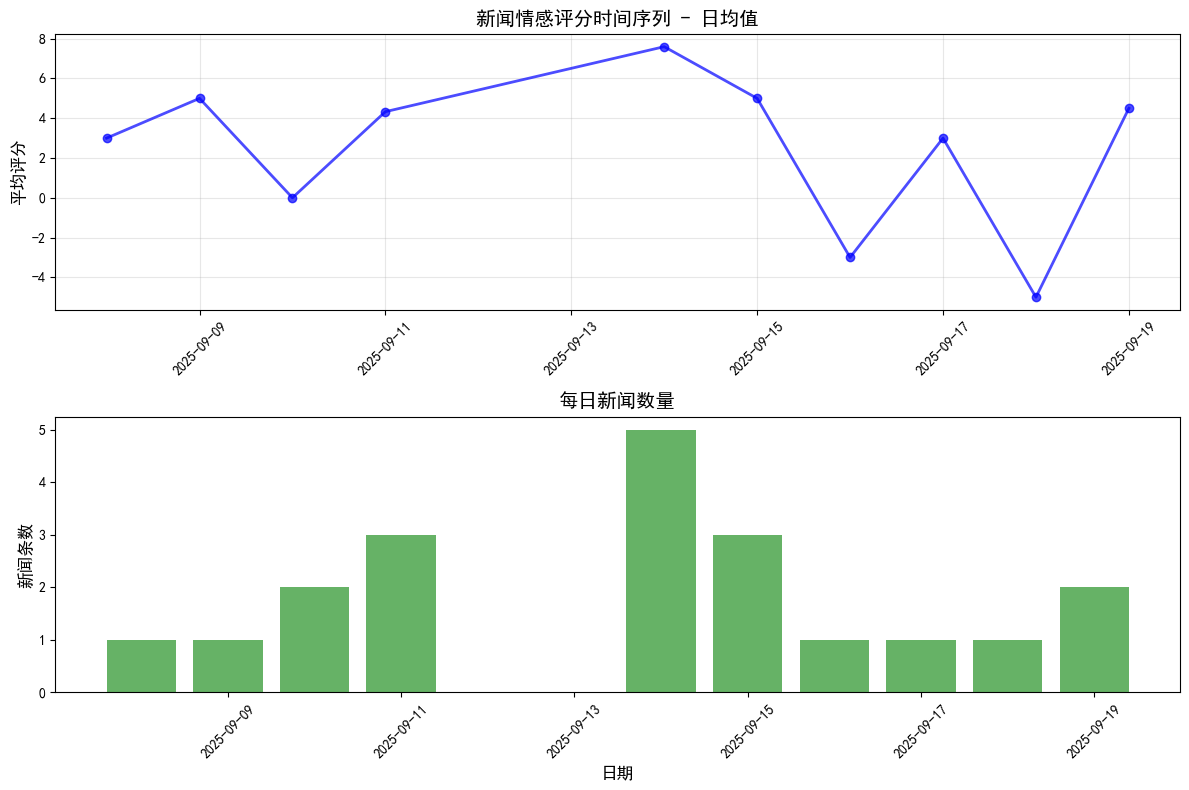

In [3]:
# 2. 按日期聚合新闻评分
daily_news_scores = news_df.groupby(news_df['date'].dt.date).agg({
    'overall_score': ['mean', 'sum', 'count'],
    'sentiment': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'neutral'
}).round(2)

# 展平列名
daily_news_scores.columns = ['score_mean', 'score_sum', 'news_count', 'dominant_sentiment']
daily_news_scores.reset_index(inplace=True)
daily_news_scores['date'] = pd.to_datetime(daily_news_scores['date'])

print("按日期聚合的新闻评分：")
print(daily_news_scores.head(10))

# 创建时间序列图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# 绘制平均评分
ax1.plot(daily_news_scores['date'], daily_news_scores['score_mean'], 
         marker='o', linewidth=2, markersize=6, color='blue', alpha=0.7)
ax1.set_title('新闻情感评分时间序列 - 日均值', fontsize=14, fontweight='bold')
ax1.set_ylabel('平均评分', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 绘制新闻数量
ax2.bar(daily_news_scores['date'], daily_news_scores['news_count'], 
        alpha=0.6, color='green', width=0.8)
ax2.set_title('每日新闻数量', fontsize=14, fontweight='bold')
ax2.set_ylabel('新闻条数', fontsize=12)
ax2.set_xlabel('日期', fontsize=12)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [2]:
# 1. 读取新闻评分数据
news_data_path = r'D:\projects\q\myQ\scripts\news_scores_result.csv'
news_df = pd.read_csv(news_data_path)

print("新闻数据基本信息：")
print(f"数据形状: {news_df.shape}")
print(f"时间范围: {news_df['original_date'].min()} 到 {news_df['original_date'].max()}")
print(f"overall_score 统计:")
print(news_df['overall_score'].describe())

# 转换时间格式
news_df['date'] = pd.to_datetime(news_df['original_date'])
news_df = news_df.sort_values('date')

print(f"\n前5条数据:")
print(news_df[['date', 'original_title', 'overall_score']].head())

新闻数据基本信息：
数据形状: (20, 15)
时间范围: 2025-09-08 14:13:02 到 2025-09-19 10:32:23
overall_score 统计:
count    20.000000
mean      3.900000
std       3.669218
min      -5.000000
25%       2.750000
50%       5.000000
75%       7.000000
max       8.000000
Name: overall_score, dtype: float64

前5条数据:
                  date                                     original_title  \
19 2025-09-08 14:13:02  紫金矿业等在池州成立新公司\n\n南方财经9月8日电，天眼查工商信息显示，近日，池州市朱庄矿...   
18 2025-09-09 14:10:01  紫金矿业旗下国际控股公司增资至180亿\n\n人民财讯9月9日电，企查查APP显示，近日，紫...   
17 2025-09-10 17:18:03  大宗交易：紫金矿业成交2.88亿元，溢价0.04%（09-10）\n\n2025年9月10日...   
16 2025-09-10 22:35:31  紫金矿业大宗交易成交2.88亿元\n\n紫金矿业9月10日大宗交易平台出现一笔成交，成交量1...   
15 2025-09-11 15:38:14  紫金矿业港股股价盘中创新高\n\n9月11日，紫金矿业港股价格盘中触及29.94港元，再度刷...   

    overall_score  
19              3  
18              5  
17              0  
16              0  
15              8  


In [1]:
# 新闻评分与股价相关性分析
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import sys
import os

# 添加项目路径
sys.path.append(r'D:\projects\q\myQ')

# 导入 market_data 模块
from quantlib.market_data import get_stock_data, MarketDataManager

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("开始新闻评分与股价相关性分析...")

开始新闻评分与股价相关性分析...


In [8]:
import requests
import json
openrouter_key='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'
response = requests.post(
  url="https://openrouter.ai/api/v1/chat/completions",
  headers={
    "Authorization": f"Bearer {openrouter_key}",
    "Content-Type": "application/json",
  },
  data=json.dumps({
    "model": "deepseek/deepseek-chat-v3.1:free",
    "messages": [
      {
        "role": "user",
        "content": "解释一下多因子策略在投资组合中的作用?用中文回答"
      }
    ],
    
  })
)

In [7]:
response.json()["choices"][0]["message"]["content"]

KeyError: 'choices'

In [5]:
import requests
import json
openrouter_key='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'
response = requests.get(
  url="https://openrouter.ai/api/v1/key",
  headers={
    "Authorization": f"Bearer {openrouter_key}"
  }
)
print(json.dumps(response.json(), indent=2))

{
  "error": {
    "message": "User not found.",
    "code": 401
  }
}


In [4]:
import pandas as pd 
df=pd.read_parquet(r'D:\projects\q\data\minute_data\000002\2025-09.parquet')

In [2]:
import requests
import json
import pandas as pd
import time
from datetime import datetime
import logging

# 设置日志
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class NewsScorer:
    def __init__(self, api_key):
        self.api_key = api_key
        self.api_url = "https://openrouter.ai/api/v1/chat/completions"
        self.headers = {
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
        }
        
        # 政策分析prompt模板
        self.policy_prompt = """
你是一位专业的金融分析师，请分析以下政策新闻对个股的影响。

背景信息：
- 股票：{stock_name}({stock_code})
- 所属行业：{industry}
- 主营业务：{main_business}
- 当前市值：{market_cap}

政策新闻：
标题：{news_title}
内容：{news_content}
发布时间：{publish_time}
消息来源：{source}

请从以下维度分析：

1. 直接影响评估
   - 政策是否直接提及该公司或其主营业务？
   - 政策对公司收入/成本/利润的潜在影响？

2. 间接影响评估
   - 对公司上下游产业链的影响？
   - 对竞争格局的影响？
   - 对行业整体的影响？

3. 影响时间判断
   - 政策落地的确定性如何？
   - 影响显现需要多长时间？

请严格按照以下JSON格式输出，不要添加任何其他文字：

{{
  "sentiment": "强烈正面|正面|中性偏正|中性|中性偏负|负面|强烈负面",
  "direct_impact": {{
    "score": {direct_score},
    "description": "直接影响说明"
  }},
  "indirect_impact": {{
    "score": {indirect_score},
    "description": "间接影响说明"
  }},
  "certainty": {certainty_score},
  "time_to_effect": "立即|1个月内|1-3个月|3-6个月|6个月以上",
  "overall_score": {overall_score},
  "risk_factors": ["风险点1", "风险点2"],
  "action_suggestion": "强烈关注|关注|观望|谨慎|回避"
}}

注意：
- direct_score和indirect_score范围：-5到+5
- overall_score范围：-10到+10
- certainty范围：0.0到1.0
- 只输出JSON，不要添加解释文字
"""

    def call_llm(self, prompt, max_retries=3):
        """调用大模型API"""
        for attempt in range(max_retries):
            try:
                data = {
                    "model": "deepseek/deepseek-chat-v3.1:free",
                    "messages": [
                        {
                            "role": "user",
                            "content": prompt
                        }
                    ],
                    "temperature": 0.1,  # 降低随机性，提高一致性
                    "max_tokens": 1000
                }
                
                response = requests.post(
                    url=self.api_url,
                    headers=self.headers,
                    data=json.dumps(data),
                    timeout=30
                )
                
                if response.status_code == 200:
                    result = response.json()
                    content = result['choices'][0]['message']['content']
                    return content
                else:
                    logger.warning(f"API请求失败，状态码: {response.status_code}, 重试 {attempt + 1}/{max_retries}")
                    if attempt < max_retries - 1:
                        time.sleep(2 ** attempt)  # 指数退避
                        
            except Exception as e:
                logger.error(f"API调用出错: {e}, 重试 {attempt + 1}/{max_retries}")
                if attempt < max_retries - 1:
                    time.sleep(2 ** attempt)
        
        return None

    def parse_llm_response(self, response_text):
        """解析大模型返回的JSON"""
        try:
            # 清理响应文本
            response_text = response_text.strip()
            if response_text.startswith('```json'):
                response_text = response_text[7:]
            if response_text.endswith('```'):
                response_text = response_text[:-3]
            response_text = response_text.strip()
            
            # 解析JSON
            result = json.loads(response_text)
            
            # 验证必要字段
            required_fields = ['sentiment', 'direct_impact', 'indirect_impact', 
                             'certainty', 'time_to_effect', 'overall_score', 
                             'risk_factors', 'action_suggestion']
            
            for field in required_fields:
                if field not in result:
                    logger.warning(f"缺少必要字段: {field}")
                    return None
            
            return result
            
        except json.JSONDecodeError as e:
            logger.error(f"JSON解析失败: {e}")
            logger.error(f"原始响应: {response_text}")
            return None
        except Exception as e:
            logger.error(f"响应解析出错: {e}")
            return None

    def score_news(self, news_row, stock_info):
        """对单条新闻进行评分"""
        try:
            # 构建prompt
            prompt = self.policy_prompt.format(
                stock_name=stock_info.get('stock_name', ''),
                stock_code=stock_info.get('stock_code', ''),
                industry=stock_info.get('industry', ''),
                main_business=stock_info.get('main_business', ''),
                market_cap=stock_info.get('market_cap', ''),
                news_title=news_row.get('title', ''),
                news_content=news_row.get('content', ''),
                publish_time=news_row.get('date', ''),
                source=news_row.get('source', ''),
                direct_score=0,  # 占位符
                indirect_score=0,  # 占位符
                certainty_score=0.5,  # 占位符
                overall_score=0  # 占位符
            )
            
            # 调用大模型
            logger.info(f"正在分析新闻: {news_row.get('title', '')[:50]}...")
            response = self.call_llm(prompt)
            
            if response is None:
                logger.error("大模型调用失败")
                return None
            
            # 解析响应
            parsed_result = self.parse_llm_response(response)
            
            if parsed_result is None:
                logger.error("响应解析失败")
                return None
            
            # 添加原始新闻信息
            parsed_result['original_title'] = news_row.get('title', '')
            parsed_result['original_date'] = news_row.get('date', '')
            parsed_result['original_source'] = news_row.get('source', '')
            parsed_result['analysis_time'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            
            logger.info(f"✓ 分析完成，综合得分: {parsed_result.get('overall_score', 0)}")
            return parsed_result
            
        except Exception as e:
            logger.error(f"新闻评分出错: {e}")
            return None

    def process_news_batch(self, csv_file, stock_info, output_file='news_scores.csv', batch_size=5):
        """批量处理新闻评分"""
        try:
            # 读取新闻数据
            logger.info(f"读取新闻数据: {csv_file}")
            df = pd.read_csv(csv_file, encoding='utf-8-sig')
            logger.info(f"共读取到 {len(df)} 条新闻")
            
            # 检查必要列
            required_columns = ['date', 'content']
            missing_columns = [col for col in required_columns if col not in df.columns]
            if missing_columns:
                raise ValueError(f"CSV文件缺少必要列: {missing_columns}")
            
            # 添加可选列的默认值
            if 'title' not in df.columns:
                df['title'] = df['content'].str[:100] + '...'
            if 'source' not in df.columns:
                df['source'] = '未知来源'
            
            # 存储评分结果
            scored_results = []
            
            # 分批处理
            for i in range(0, len(df), batch_size):
                batch = df.iloc[i:i+batch_size]
                logger.info(f"处理批次 {i//batch_size + 1}/{(len(df)-1)//batch_size + 1}")
                
                for idx, row in batch.iterrows():
                    logger.info(f"处理第 {idx + 1}/{len(df)} 条新闻")
                    
                    # 评分
                    score_result = self.score_news(row.to_dict(), stock_info)
                    
                    if score_result:
                        # 展平结果用于DataFrame
                        flattened_result = {
                            'news_id': idx + 1,
                            'original_title': score_result['original_title'],
                            'original_date': score_result['original_date'],
                            'original_source': score_result['original_source'],
                            'analysis_time': score_result['analysis_time'],
                            'sentiment': score_result['sentiment'],
                            'direct_impact_score': score_result['direct_impact']['score'],
                            'direct_impact_desc': score_result['direct_impact']['description'],
                            'indirect_impact_score': score_result['indirect_impact']['score'],
                            'indirect_impact_desc': score_result['indirect_impact']['description'],
                            'certainty': score_result['certainty'],
                            'time_to_effect': score_result['time_to_effect'],
                            'overall_score': score_result['overall_score'],
                            'risk_factors': '|'.join(score_result.get('risk_factors', [])),
                            'action_suggestion': score_result['action_suggestion']
                        }
                        scored_results.append(flattened_result)
                    else:
                        logger.warning(f"第 {idx + 1} 条新闻评分失败，跳过")
                    
                    # 避免请求过频
                    time.sleep(1)
                
                # 批次间休息
                if i + batch_size < len(df):
                    logger.info("批次间休息 3 秒...")
                    time.sleep(3)
            
            # 保存结果
            if scored_results:
                results_df = pd.DataFrame(scored_results)
                results_df.to_csv(output_file, index=False, encoding='utf-8-sig')
                logger.info(f"评分结果已保存到: {output_file}")
                logger.info(f"成功处理 {len(results_df)} 条新闻")
                
                # 显示统计信息
                self.show_statistics(results_df)
                
                return results_df
            else:
                logger.error("没有成功处理的新闻")
                return pd.DataFrame()
                
        except Exception as e:
            logger.error(f"批量处理出错: {e}")
            return pd.DataFrame()

    def show_statistics(self, df):
        """显示评分统计信息"""
        logger.info("\n=== 评分统计 ===")
        logger.info(f"总新闻数: {len(df)}")
        logger.info(f"平均综合得分: {df['overall_score'].mean():.2f}")
        logger.info(f"情绪分布:")
        sentiment_counts = df['sentiment'].value_counts()
        for sentiment, count in sentiment_counts.items():
            logger.info(f"  {sentiment}: {count} 条")
        
        logger.info(f"行动建议分布:")
        action_counts = df['action_suggestion'].value_counts()
        for action, count in action_counts.items():
            logger.info(f"  {action}: {count} 条")

# 使用示例
if __name__ == "__main__":
    # API配置
    openrouter_key = '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'
    
    # 创建评分器
    scorer = NewsScorer(openrouter_key)
    
    # 股票信息
    stock_info = {
        'stock_name': '紫金矿业',
        'stock_code': '601899',
        'industry': '有色金属',
        'main_business': '黄金、铜等有色金属的开采、选矿、冶炼及销售',
        'market_cap': '3000亿元'
    }
    
    # 处理新闻评分
    results_df = scorer.process_news_batch(
        csv_file='news_data.csv',
        stock_info=stock_info,
        output_file='news_scores_result.csv',
        batch_size=3  # 小批量处理，避免API限制
    )
    
    if not results_df.empty:
        print("\n=== 处理完成 ===")
        print(f"成功评分 {len(results_df)} 条新闻")
        print("结果文件: news_scores_result.csv")
        
        # 显示前几条结果
        print("\n=== 前3条评分结果 ===")
        for idx, row in results_df.head(3).iterrows():
            print(f"\n{idx+1}. {row['original_title'][:50]}...")
            print(f"   情绪: {row['sentiment']}")
            print(f"   综合得分: {row['overall_score']}")
            print(f"   建议: {row['action_suggestion']}")
    else:
        print("处理失败，请检查输入文件和配置")

2025-09-22 16:35:47,175 - INFO - 读取新闻数据: news_data.csv
2025-09-22 16:35:47,203 - INFO - 共读取到 20 条新闻
2025-09-22 16:35:47,217 - INFO - 处理批次 1/7
2025-09-22 16:35:47,219 - INFO - 处理第 1/20 条新闻
2025-09-22 16:35:47,219 - INFO - 正在分析新闻: 紫金矿业子公司紫金黄金国际拟香港联交所上市 发行价71.59港元/股

上证报中国证券网讯（记者王乔...
2025-09-22 16:35:55,198 - INFO - ✓ 分析完成，综合得分: 4
2025-09-22 16:35:56,210 - INFO - 处理第 2/20 条新闻
2025-09-22 16:35:56,212 - INFO - 正在分析新闻: 每股71.59港元 紫金矿业旗下紫金黄金国际启动港股公开发售，9月29日挂牌交易

9月19日，紫金...
2025-09-22 16:36:04,485 - INFO - ✓ 分析完成，综合得分: 5
2025-09-22 16:36:05,502 - INFO - 处理第 3/20 条新闻
2025-09-22 16:36:05,503 - INFO - 正在分析新闻: 有色金属行业资金流出榜：北方稀土、紫金矿业等净流出资金居前

沪指9月18日下跌1.15%，申万所属...
2025-09-22 16:36:16,701 - INFO - ✓ 分析完成，综合得分: -5
2025-09-22 16:36:17,715 - INFO - 批次间休息 3 秒...
2025-09-22 16:36:20,716 - INFO - 处理批次 2/7
2025-09-22 16:36:20,717 - INFO - 处理第 4/20 条新闻
2025-09-22 16:36:20,718 - INFO - 正在分析新闻: 藏格矿业：紫金矿业入主后，藏格矿业仍将战略重心聚焦于钾、锂上游资源的开发与运营

每经AI快讯，有投...
2025-09-22 16:36:42,229 - INFO - ✓ 分析完成，综合得分: 3
2025-09-22 16


=== 处理完成 ===
成功评分 20 条新闻
结果文件: news_scores_result.csv

=== 前3条评分结果 ===

1. 紫金矿业子公司紫金黄金国际拟香港联交所上市 发行价71.59港元/股

上证报中国证券网讯（记者王乔...
   情绪: 中性偏正
   综合得分: 4
   建议: 关注

2. 每股71.59港元 紫金矿业旗下紫金黄金国际启动港股公开发售，9月29日挂牌交易

9月19日，紫金...
   情绪: 中性偏正
   综合得分: 5
   建议: 关注

3. 有色金属行业资金流出榜：北方稀土、紫金矿业等净流出资金居前

沪指9月18日下跌1.15%，申万所属...
   情绪: 中性偏负
   综合得分: -5
   建议: 观望


In [7]:
import sys
import os

# 添加项目路径
sys.path.append(r'D:\projects\q\myQ')
from quantlib.market_data import get_stock_data

In [11]:
from quantlib.market_data import MarketDataManager
manager = MarketDataManager()
data = manager.get_stock_data('601899', market='CN', period='1mo', interval='1d')

× 601899: 获取A股数据失败 - '1d'


[{'title': '平安银行新增一副行长！',
  'date': '',
  'url': 'http://finance.eastmoney.com/a/202503223353216668.html',
  'source': '中国基金报',
  'summary': '【导读】方蔚豪拟出任平安银行副行长，曾任平安信托董事长 \u3000\u30003月21日晚间，平安银行发布董事会决议公告称，同意聘任方蔚豪为平安银行副行长，任职须报国家金融监督管理总局核准。 \u3000\u3000这意味着，平安银行在召开2024年度业绩说明会后仅间隔3日，便迅速再添一名新副行长。',
  'stock_code': '000001'},
 {'title': '平安银行：监事会决议公告',
  'date': '',
  'url': 'http://finance.eastmoney.com/a/202504193381632686.html',
  'source': '证券日报',
  'summary': '证券日报网讯 4月18日晚间，平安银行发布公告称，公司第十一届监事会第十四次会议审议通过了《平安银行股份有限公司2025年第一季度报告》《平安银行股份有限公司2024年度董事履职评价报告》等多项议案。',
  'stock_code': '000001'},
 {'title': '平安银行副行长定了！',
  'date': '',
  'url': 'http://finance.eastmoney.com/a/202506273442387261.html',
  'source': '21世纪经济报道',
  'summary': '时隔三月，方蔚豪平安银行副行长任职获监管部门核准。 \u3000\u3000近日，平安银行发布公告称收到《国家金融监督管理总局关于方蔚豪平安银行副行长任职资格的批复》（金复〔2025〕377号），国家金融监督管理总局核准方蔚豪平安银行股份有限公司副行长的任职资格。',
  'stock_code': '000001'},
 {'title': '平安银行：董事会决议公告',
  'date': '',
  'url': 'http://finance.eastmoney.com/a/20250321335273566